# Text tree edit distance: a language model-based metric for text hierarchy comparison.

This notebook contains the implementation of a simple yet informative metric for text tree comparison. This way of text tree similarity measurement can be used, for example, to compare sentence-based mind maps generated by a neural network with reference maps to assess generation quality. The way this algorithm works is by using the Zhang-Shasha algorithm to compute tree edit distance with semantic distance between the sentences in the nodes as the cost of node updates. To measure semantic distance between sentences, we compute the distance between the sentences' embeddings produced by an encoder language model.

The Zhang-Shasha algorithm implementation used here is from the `edist` Python library developed by Benjamin Paassen (2019-2021).

## Prerequisites

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import time
from tqdm.notebook import tqdm
import json

import warnings
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer, SimilarityFunction

from tted.tree_format import TextTree
from tted.computation import text_tree_distance
from tted.baseline import baseline_distance, baseline_similarity

In [2]:
# Plot formatting
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

We will use text trees stored in the JSON format as in the following example:
```json
{
  "A new algorithm for text tree edit distance based on Zhang-Shasha's algorithm and BERT-like model embedding similarity.": {
    "The algorithm's novelty is in its similarity measure based on BERT-like model embeddings.": {
      "Embedding distance is used as a measure of semantic similarity.": {},
      "The language model allows to capture semantic meaning of sentences and model their similarity.": {}
    },
    "Zhang-Shasha's algorithm is used to compute tree edit distance with new edit costs.": {
      "Semantic similarity is used as the update cost in the algorithm.": {},
      "The costs of insertion and removal of nodes are defined as the similarity of the node and an empty sentence.": {}
    },
    "The proposed algorithm is presented as a more informative metric of similarity between text trees.": {
      "The current ways of comparing text trees overlook their tree structure or the meaning of their labels.": {},
      "This new method can be used, for example, to compare mind maps or hierarchical summaries.": {}
    }
  }
}
```
We use the similarity function from "Coherence Graph Guidance for Mind-Map Generation" (Zhang et al., 2024) and a pseudometric based on it as a baseline for comparison. The full original code from this paper can be found at https://github.com/Cyno2232/CMGN.

## Basic tests

Below we provide an example use case of the functions above utilizing a model from `sentence_transformers`:

In [3]:
A = TextTree([
    'We present a new metric for text tree comparison.', 
    'It uses Zhang-Shasha\'s algorithm and a BERT-like model.', 
    'Zhang-Shasha\'s algorithm is used to measure tree edit distance effectively.', 
    'The BERT-like model is used to measure semantic similarity.', 
    'The algorithm is presented as an informative metric for text tree comparison.', 
    'There hasn\'t yet been a metric that allows to compare tree-structured text data such as mind maps informatively.', 
    'This metric can be used, for example, to evaluate automatic salient sentence-based mind map generation.'
],
[[1, 4], [2, 3], [], [], [5, 6], [], []])

B = TextTree([
    'A new metric for text tree comparison based on tree edit distance and semantic similarity.',
    'Zhang-Shasha\'s algorithm is used to compute tree edit distance.', 
    'Semantic similarity is measured using a BERT-like language model.', 
    'To measure it, the sentences with all parent nodes as context are passed to the language model.', 
    'Semantic similarity is measured as the similarity of the model\'s embeddings of the sentences.', 
    'This metric can be used to compare text trees.', 
    'For example, it can be utilized in automatic mind map generation evaluation against reference maps.'
],
[[1, 2, 5], [], [3, 4], [], [], [6], []])

In [4]:
model = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v2')
def cos_dist(a_embedding, b_embedding):
        return np.sqrt(1 - model.similarity(a_embedding, b_embedding))

In [5]:
%%time

AB_dist = text_tree_distance(A, B, model.encode, cos_dist, unordered=False, use_context=False)
print(AB_dist)

5.4731113612651825
CPU times: total: 1.25 s
Wall time: 160 ms


In [6]:
%%time

AB_base_dist = baseline_distance(A, B)
print(AB_base_dist)

2.9569458062757326
CPU times: total: 1.36 s
Wall time: 182 ms


## Main experiment

Now we can run a couple of experiments to evaluate these two metrics on simple test cases. We'll compare the methods on three text tree sets, each based on the tree `C` from the example above:
1) A set of trees that are identical in semantic meaning and structure, but the sentences in the tree nodes are paraphrased;
2) A set of trees that are formed from the same sentences, but in different tree order;
3) A set of trees that have identical structure but are significantly different in meaning.

For each set of trees we'll compute pairwise similarity scores with my metric and the baseline method. The goal is to capture the difference in meaning and structure of the trees while minimizing the distance between trees that are, in a sense, paraphrases of each other.

### Helper functions

In [16]:
def run_test(method, model=None, dist=None, unordered=True, use_context=False, filename=None):
    scores = {}
    times = {}
    
    test_cases = ['paraphrase', 'meaning', 'structure']
    sizes = [5, 10, 15, 20, 25]
    set_count = 5
    sample_count = 5

    for size in tqdm(sizes, leave=False):
        scores[size] = {}
        for test_case in test_cases:
            scores[size][test_case] = []
        for k in tqdm(range(set_count), leave=False):
            base_tree = TextTree.from_json(f'data/tted_test/size_{size}/set_{k}/base_tree.json')
            total_time = 0
            for test_case in test_cases:
                path = f'data/tted_test/size_{size}/set_{k}/{test_case}_'
        
                trees = []
                for i in range(sample_count):
                    trees.append(TextTree.from_json(path + str(i) + '.json'))
        
                start_time = time.time()
                for i in range(sample_count):
                    if method == 'tted':
                        new_dist = text_tree_distance(
                            base_tree, trees[i], 
                            encoder=model, 
                            embedding_dist=dist, 
                            unordered=unordered, 
                            use_context=use_context
                        )
                    elif method == 'baseline':
                        new_dist = baseline_distance(base_tree, trees[i])
                    elif method == 'baseline_sim':
                        new_dist = baseline_similarity(base_tree, trees[i])
                    else:
                        pass

                    if not np.isnan(new_dist):
                        scores[size][test_case].append(new_dist)
        
                total_time += time.time() - start_time

        times[size] = total_time / (set_count * sample_count * len(test_cases))

    if filename:
        data_path = 'data/results/'
        with open(data_path+filename, 'w') as f:
            json.dump(scores, f, indent=4)
    
    return scores, times

In [8]:
def boxplot_scores(scores, plot_title, filename):
    fig, ax = plt.subplots(figsize=(7, 5))

    ax.boxplot(scores.values(), vert=False)

    ax.set_xlabel(r'$\rho(T, \cdot)$')
    ax.set_xlim(0)
    ax.set_yticklabels(scores.keys())
    ax.grid()
    if plot_title is not None:
        ax.set_title(plot_title)

    fig.savefig('../img/' + filename, bbox_inches='tight', pad_inches=0.1)

    plt.show()

In [57]:
def plot_scores(scores, plot_title, filename):
    exps = ('paraphrase', 'structure', 'meaning')
    size_range = np.arange(5, 26, 5)

    markers = ['x', 'o', '*']
    for exp, marker in zip(exps, markers):
        means = np.array([np.mean(scores[n][exp]) for n in size_range])
        stds = np.array([np.std(scores[n][exp]) for n in size_range])
        plt.plot(size_range, means, label=exp, marker=marker)
        plt.fill_between(size_range, means - stds, means + stds, alpha=0.25)
    
    plt.xlabel(r'Tree size, $|T|$')
    plt.ylabel(r'Mean distance, $\overline{\rho}$') # For distance
    # plt.ylabel(r'Mean similarity, $\overline{\text{Sim}}$') # For similarity
    plt.ylim(0)
    plt.grid()
    plt.legend()
    
    plt.savefig("../img/"+filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [10]:
def result_frame(scores, method_name):
    results_array = [method_name]
    
    for exp in ('paraphrase', 'structure', 'meaning'):
        results_array.append(np.mean(scores[10][exp]))
        results_array.append(np.std(scores[10][exp]))
    for exp in ('structure', 'meaning'):
        quality_coeffs = []
        for size in scores.keys():
            quality_coeffs.extend([a / b for a in scores[size]['paraphrase'] for b in scores[size][exp]])
        results_array.append(np.mean(quality_coeffs))
        results_array.append(np.std(quality_coeffs))

    results_array = [results_array]
    frame = pd.DataFrame(results_array, columns=['Method', 
                                                 'Paraphrase mean', 
                                                 'Paraphrase std', 
                                                 'Restructure mean',
                                                 'Restructure std',
                                                 'Meaning mean', 
                                                 'Meaning std', 
                                                 'R_S score',
                                                 'R_S std',
                                                 'R_M score',
                                                 'R_M std'])
    return frame

### Experiment runs

Below are our experiments with several language models and distance metrics, with and without context usage, in comparison to the baseline method:

In [11]:
scores_dict = {}
times_dict = {}

In [12]:
scores_dict['baseline'], _ = run_test('baseline', filename='baseline.json')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
baseline_sims, times_dict['baseline'] = run_test('baseline_sim', filename='baseline_sim.json')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
model_names = ['sentence-transformers/paraphrase-distilroberta-base-v2',
              'sentence-transformers/allenai-specter',
              'sentence-transformers/all-mpnet-base-v2',
              'sentence-transformers/paraphrase-multilingual-mpnet-base-v2']
model_labels = ['distilroberta',
                'specter',
                'mpnet',
                'tuned_mpnet']

In [17]:
for model_name, model_label in zip(model_names, model_labels):
    model = SentenceTransformer(model_name)

    # The default similarity function for all of the models above is the cosine similarity function
    def dist(a_embedding, b_embedding):
        return float(np.sqrt(1 - model.similarity(a_embedding, b_embedding)))

    scores_dict[model_name], times_dict[model_name] = run_test('tted', model=model.encode, dist=dist, filename=model_label+'.json')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [47]:
# Experiment with different distance measures
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
for sim_measure, measure_name in zip([SimilarityFunction.EUCLIDEAN, SimilarityFunction.MANHATTAN], ['euclidian', 'manhattan']):
    model.similarity_fn_name = sim_measure
    def dist(embedding_a, embedding_b):
        return float(-model.similarity(embedding_a, embedding_b))
        
    scores_dict[measure_name], times_dict[measure_name] = run_test('tted', model=model.encode, dist=dist, filename=measure_name+'.json')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [48]:
# Experiment with context usage
model.similarity_fn_name = SimilarityFunction.COSINE
def dist(a_embedding, b_embedding):
    return float(np.sqrt(1 - model.similarity(a_embedding, b_embedding)))

scores_dict['With context'], times_dict['With context'] = run_test('tted', model=model.encode, dist=dist, use_context=True, filename='context.json')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
for exp in scores_dict.keys():
    for size in scores_dict[exp].keys():
        for case in scores_dict[exp][size].keys():
            npar = np.array(scores_dict[exp][size][case])
            scores_dict[exp][size][case] = npar[npar != 0]

### Results

In [53]:
frames_dict = {}
method_names = ['Baseline method',
                'TTED with fine-tuned DistilRoBERTa',
                'TTED with SPECTER',
                'TTED with untuned MPNet',
                'TTED with fine-tuned MPNet',
                'TTED with MPNet and Euclidian distance',
                'TTED with MPNet and Manhattan distance',
                'TTED with MPNet and context']

for exp_name, method_name in zip(scores_dict.keys(), method_names):
    frames_dict[exp_name] = result_frame(scores_dict[exp_name], method_name)

In [54]:
final_frame = pd.concat(frames_dict.values())
final_frame

,Method,Paraphrase mean,Paraphrase std,Restructure mean,Restructure std,Meaning mean,Meaning std,R_S score,R_S std,R_M score,R_M std
0,Baseline method,3.525337,0.203994,2.103426,0.559043,3.746898,0.165275,2.051749,0.790708,0.958523,0.102269
0,TTED with fine-tuned DistilRoBERTa,4.243288,0.703752,8.894341,1.697063,8.196382,0.716032,0.576515,0.223366,0.533011,0.112310
0,TTED with SPECTER,2.464432,0.718957,4.507806,1.355263,5.547088,0.785702,0.694583,0.350488,0.457531,0.137180
0,TTED with untuned MPNet,3.889405,0.706553,9.127640,1.727933,8.406544,0.802795,0.441960,0.119848,0.476278,0.113274
0,TTED with fine-tuned MPNet,3.306886,0.668176,8.608000,2.114146,7.663653,0.824694,0.607226,0.783379,0.446629,0.118747
0,TTED with MPNet and Euclidian distance,5.500451,0.999217,9.255229,3.562085,11.888648,1.135323,0.815510,0.466806,0.476279,0.113274
0,TTED with MPNet and Manhattan distance,119.703552,21.602166,201.743041,77.350526,259.054025,25.120966,0.814442,0.466638,0.475982,0.113036
0,TTED with MPNet and context,3.085498,0.750684,8.412848,2.194332,8.720093,0.572277,0.426572,0.185157,0.346788,0.084257


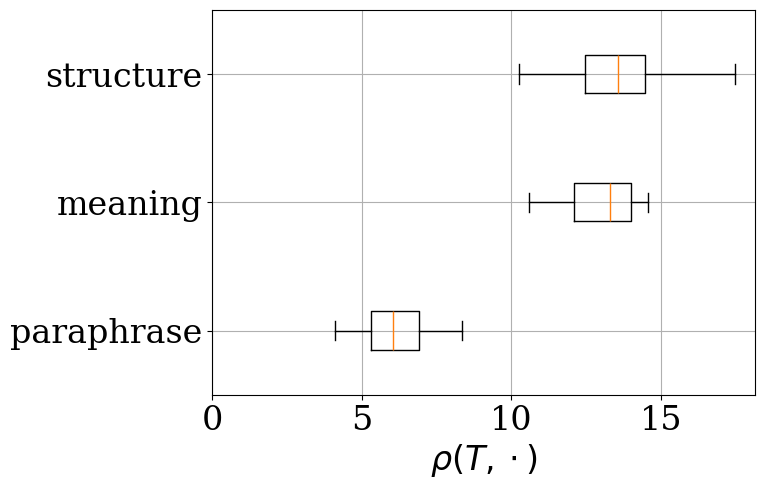

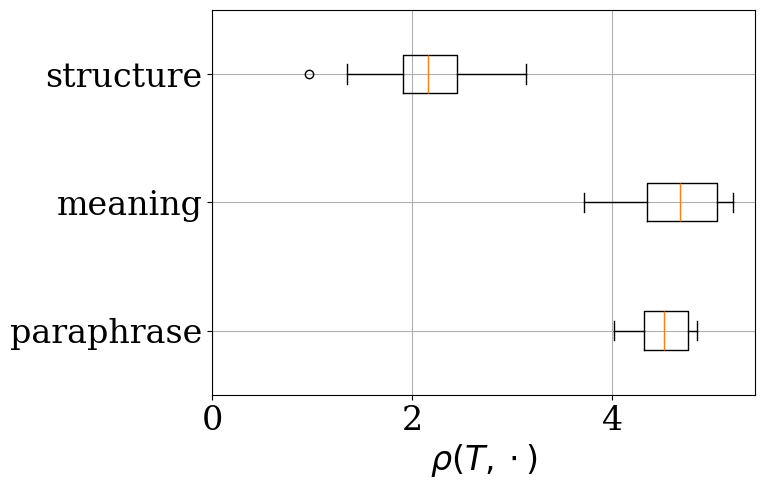

In [38]:
boxplot_scores(scores_dict['sentence-transformers/all-mpnet-base-v2'][15], 
            '',
            'mpnet_box.png')
boxplot_scores(scores_dict['baseline'][15], '', 'baseline_box.png')

### Distance scores for different tree sizes

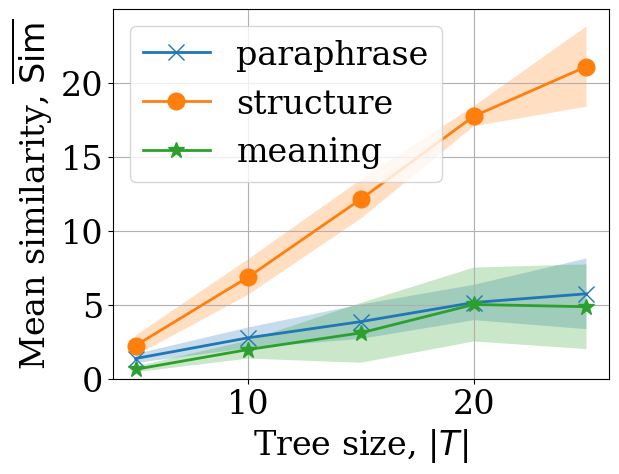

In [56]:
plot_scores(baseline_sims, '', 'baseline_sim_graph.png')

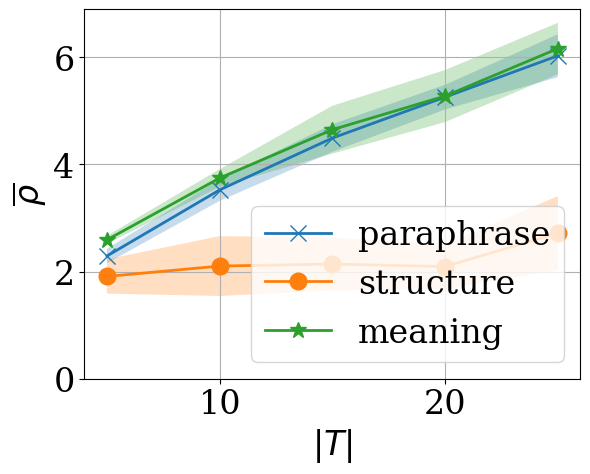

In [41]:
plot_scores(scores_dict['baseline'], '', 'baseline_graph.png')

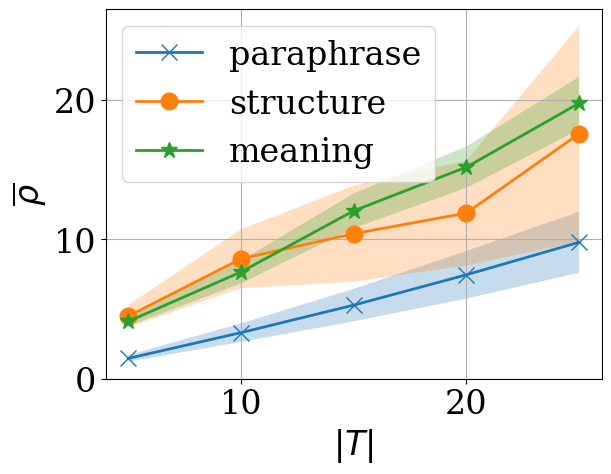

In [42]:
plot_scores(scores_dict['sentence-transformers/paraphrase-multilingual-mpnet-base-v2'], '', 'tuned_mpnet_graph.png')

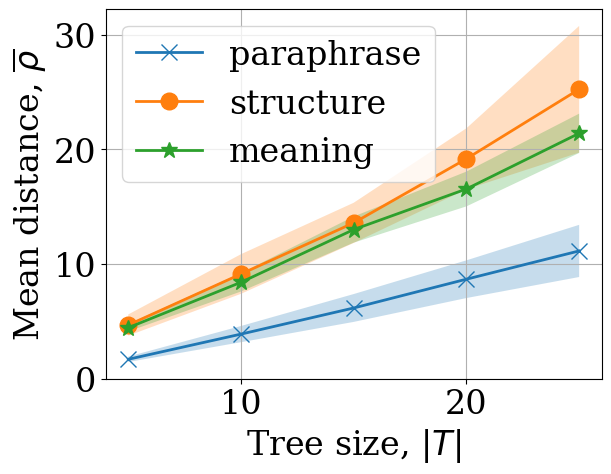

In [58]:
plot_scores(scores_dict['sentence-transformers/all-mpnet-base-v2'], '', 'mpnet_graph.png')

## Computation time measurement

Here, we measure the time that it takes to compute TTED and the baseline similarity score for full binary text trees of depths 2 to 6 to see how the two methods scale.

In [ ]:
# max_depth = 9
# n_range = np.arange(2, max_depth+1)
# sample_count = 5

# def measure_time(func):
#     times = {}
#     for n in tqdm(n_range):
#         times[n] = []
#         trees = []
#         for i in range(sample_count):
#             trees.append(TextTree.from_json(f'data/tted_time_test/depth_{n}/map_{i}.json'))
                                      
#         for i in range(sample_count - 1):
#             for j in range(i+1, sample_count):
#                 start_time = time.time()
#                 func(trees[i], trees[j])
#                 times[n].append(time.time() - start_time)
                
#     return times

In [ ]:
# baseline_times = measure_time(baseline_similarity)

In [ ]:
# measured_times = []

# def cos_dist(a_embedding, b_embedding):
#         return float(1 - model.similarity(a_embedding, b_embedding))

# for i in range(len(model_names)):
#     model = SentenceTransformer(model_names[i])
#     func = lambda a, b: text_tree_distance(a, b, model.encode, cos_dist, False)
#     measured_times.append(measure_time(func))

In [ ]:
# model_labels = [
#     'TTED with paraphrase DistilRoBERTa',
#     'TTED with SPECTER',
#     'TTED with untuned MPNet',
#     'TTED with paraphrase MPNet'
# ]
# plt.rcParams['legend.fontsize'] = 12

# for i in range(len(model_names)):
#     means = np.array([np.mean(measurement) for measurement in measured_times[i].values()])
#     stds = np.array([np.std(measurement) for measurement in measured_times[i].values()])
#     plt.plot(n_range, means, label=model_labels[i])
#     plt.fill_between(n_range, means - stds, means + stds, alpha=0.25)

# means = np.array([np.mean(measurement) for measurement in baseline_times.values()])
# stds = np.array([np.std(measurement) for measurement in baseline_times.values()])
# plt.plot(n_range, means, linestyle='--', label="Baseline")
# plt.fill_between(n_range, means - stds, means + stds, alpha=0.25)

# plt.xlabel(r'$d$')
# plt.ylabel(r'$t$, с')
# plt.yscale('log')
# plt.grid()
# plt.legend()

# plt.savefig("../img/computation_times.png", bbox_inches='tight', pad_inches=0.1)
# plt.show()